# Method to the Madness:
Using machine learning techniques to predict the outcomes of march madness games.

Cameron Bale and Neil Duzett

https://en.wikipedia.org/wiki/Elo_rating_system
    
https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/
    
https://github.com/fivethirtyeight/nfl-elo-game/blob/master/forecast.py

The idea here is to get another feature to be plugged in when predicting tournament games.

In [239]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
pd.set_option('display.max_columns', None)
import scipy as sci # math ops
import seaborn as sns # visualizations
import matplotlib.pyplot as plt # for plottings
%matplotlib inline
#Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

The following parameter K affects how quickly the Elo adjusts to new information. Here we're just using the value that 538 found most appropriate for the NBA -- we haven't done any analysis around whether this value is also the best in terms of college basketball.

We also use the same home-court advantage as 538: the host team gets an extra 100 points added to their Elo.

In [240]:
K = 20
HOME_ADVANTAGE = 100

In [241]:
rs = pd.read_csv("/Users/Neil/Desktop/2018/RegularSeasonCompactResults_Prelim2018.csv")
rs.head(5)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [242]:
team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
len(team_ids)

364

We'll initialise all teams with a rating of 1500. There are two differences here with from 538 approach:

New entrants (when and where there are any) will start at the average 1500 Elo rather than a lower rating probably more appropriate for a new team.
There is no reversion to the mean between seasons. Each team's Elo starts exactly where it left off the previous season. Our justification here is that we only care about the end-of-season rating in terms of making predictions on the NCAA tournament, so even if ratings are a little off at first, they have the entire regular season to converge to something more appropriate.

In [243]:
# This dictionary will be used as a lookup for current
# scores while the algorithm is iterating through each game
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

# Elo updates will be scaled based on the margin of victory
rs['margin'] = rs.WScore - rs.LScore



The following functions constitute the majority of the ELO calculation.

In [244]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [245]:
# We'll iterate over the games dataframe using 
# index numbers, so want to check that nothing is out
# of order before doing that.
assert np.all(rs.index.values == np.array(range(rs.shape[0]))), "Index is out of order."

In [246]:
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in rs.itertuples():
    
    # Get key data from current row
    w = row.WTeamID
    l = row.LTeamID
    margin = row.margin
    wloc = row.WLoc
    
    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0., 0.
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad,
                              elo_dict[l] + l_ad, 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    
    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

In [247]:
rs['w_elo'] = w_elo
rs['l_elo'] = l_elo

In [248]:
rs.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,margin,w_elo,l_elo
155397,2018,115,1430,70,1167,47,A,0,23,1516.011671,1434.138860
155398,2018,115,1431,74,1256,72,H,0,2,1410.462604,1585.207197
155399,2018,115,1442,82,1295,74,H,0,8,1328.461941,1493.969561
155400,2018,115,1443,93,1150,55,H,0,38,1625.082152,1328.580419
155401,2018,115,1447,64,1148,62,A,0,2,1478.518078,1159.317348
155402,2018,115,1450,78,1143,76,A,0,2,1501.066460,1559.703254
155403,2018,115,1453,96,1324,90,A,0,6,1436.402898,1593.833098
155404,2018,115,1454,72,1178,49,A,0,23,1443.475431,1298.116834
155405,2018,115,1456,96,1423,83,H,0,13,1520.511670,1490.599152
155406,2018,115,1458,70,1321,64,A,0,6,1788.427495,1712.872325


In [249]:
np.mean(-np.log(preds))

0.5323409486046118

(This is a pretty rough measure, because this is looking only at regular-season games, which is not really what we're ultimately interested in predicting.)

Final step: for each team, pull out the final Elo rating at the end of each regular season. This is a bit annoying because the team ID could be in either the winner or loser column for their last game of the season.

In [250]:
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.Season,
        'season_elo': d.season_elo
    })
    return(out)

df_list = [final_elo_per_season(rs, id) for id in team_ids]
season_elos = pd.concat(df_list)

season_elos.sample(10)

,team_id,season,season_elo
83126,1382,2004,1488.8
139910,1218,2015,1542.06
69461,1329,2001,1832.36
35595,1278,1993,1724.41
43690,1151,1995,1646.94
31355,1358,1992,1156.6
64776,1237,2000,1313.91
64855,1141,2000,1307.77
113378,1436,2010,1575.35
150649,1186,2017,1498.17


In [251]:
season_elos.to_csv("season_elos.csv", index=None)

Now that we've created that feature, let's move on to importing the rest of the data.

## Teams

In [252]:
teams = pd.read_csv("/Users/Neil/Desktop/2018/Teams.csv")
#Glimpsing data
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [253]:
#Showing which teams aren't in this year's regular season
mask1 = (teams['LastD1Season'] != 2018 )
print("teams which aren't in 351 teams are :",list(teams[mask1]['TeamName']))

teams which aren't in 351 teams are : ['Alliant Intl', 'Armstrong St', 'Augusta', 'Birmingham So', 'Brooklyn', 'Centenary', 'Hardin-Simmons', 'Morris Brown', 'NE Illinois', 'Okla City', 'Utica', 'W Salem St', 'W Texas A&M']


## Seasons

In [254]:
seasons = pd.read_csv("/Users/Neil/Desktop/2018/Seasons.csv")
seasons.head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


## Seed

In [255]:
seed = pd.read_csv("/Users/Neil/Desktop/2018/NCAATourneySeeds.csv")
seed.tail()

,Season,Seed,TeamID
2213,2018,Z13,1422
2214,2018,Z14,1285
2215,2018,Z15,1252
2216,2018,Z16a,1300
2217,2018,Z16b,1411


In [256]:
seed.groupby(by='Season').count().tail(10)

,Seed,TeamID
Season,,
2009,65,65
2010,65,65
2011,68,68
2012,68,68
2013,68,68
2014,68,68
2015,68,68
2016,68,68
2017,68,68


In [257]:
#Separating seed into no and region
seed['region'] = seed['Seed'].apply(lambda x: x[0])
seed['no'] = seed['Seed'].apply(lambda x: x[1:])

In [258]:
seed.head()

,Season,Seed,TeamID,region,no
0,1985,W01,1207,W,01
1,1985,W02,1210,W,02
2,1985,W03,1228,W,03
3,1985,W04,1260,W,04
4,1985,W05,1374,W,05


In [259]:
print("no. of unique characters in region column in seed data=",len(set(seed['region'])))

no. of unique characters in region column in seed data= 4


In [260]:
print("no. of unique characters in no column in seed data=",len(set(seed['no'])))

no. of unique characters in no column in seed data= 26


In [261]:
print("unique seed values are",set(seed['no']))

unique seed values are {'11a', '13b', '13a', '05', '14', '12', '08', '06', '10', '07', '02', '14b', '03', '11', '16a', '01', '04', '14a', '11b', '12a', '09', '15', '13', '12b', '16', '16b'}


In [262]:
seed['no_len'] = seed['no'].apply(lambda x: len(x))
seed_first_four = seed[seed['no_len']>2]
seed_first_four.tail()

,Season,Seed,TeamID,region,no,no_len
2167,2018,W16b,1347,W,16b,3
2178,2018,X11a,1113,X,11a,3
2179,2018,X11b,1393,X,11b,3
2216,2018,Z16a,1300,Z,16a,3
2217,2018,Z16b,1411,Z,16b,3


## Regular Season Compact Results

In [263]:
rscr = pd.read_csv("/Users/Neil/Desktop/2018/RegularSeasonCompactResults_Prelim2018.csv")
rscr.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [264]:
len(set(rscr['WTeamID']))

364

In [265]:
print("percentage of games where Overtime was played = ",round(len(rscr[rscr['NumOT']>0])/len(rscr)*100,4))

percentage of games where Overtime was played =  3.8409


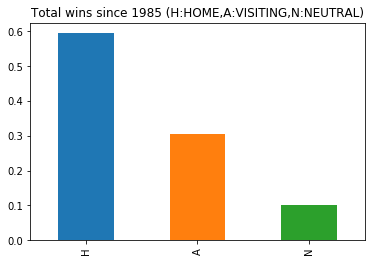

In [266]:
(rscr['WLoc'].value_counts()/len(rscr)).plot(kind='bar',title='Total wins since 1985 (H:HOME,A:VISITING,N:NEUTRAL)')

## NCAA Tourney Compact Results

## Regular Season Detailed Results

In [267]:
rsdr = pd.read_csv("/Users/Neil/Desktop/2018/RegularSeasonDetailedResults_Prelim2018.csv")
rsdr.head(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
5,2003,11,1458,81,1186,55,H,0,26,57,6,12,23,27,12,24,12,9,9,3,18,20,46,3,11,12,17,6,22,8,19,4,3,25
6,2003,12,1161,80,1236,62,H,0,23,55,2,8,32,39,13,18,14,17,11,1,25,19,41,4,15,20,28,9,21,11,30,10,4,28
7,2003,12,1186,75,1457,61,N,0,28,62,4,14,15,21,13,35,19,19,7,2,21,20,59,4,17,17,23,8,25,10,15,14,8,18
8,2003,12,1194,71,1156,66,N,0,28,58,5,11,10,18,9,22,9,17,9,2,23,24,52,6,18,12,27,13,26,13,25,8,2,18
9,2003,12,1458,84,1296,56,H,0,32,67,5,17,15,19,14,22,11,6,12,0,13,23,52,3,14,7,12,9,23,10,18,1,3,18


In [268]:
#How many teams in 2017 in regular season
len(set(rsdr[(rsdr['Season'] ==2018)]['LTeamID']))

351

In [269]:
#2 point throws for winning team
rsdr['WFGM2'] = rsdr['WFGM'] - rsdr['WFGM3']
rsdr['WFGA2'] = rsdr['WFGA'] - rsdr['WFGA3']
#2 point throws for losing teamm
rsdr['LFGM2'] = rsdr['LFGM'] - rsdr['LFGM3']
rsdr['LFGA2'] = rsdr['LFGA'] - rsdr['LFGA3']

In [270]:
#Creating list of columns
clms=['Score','EScore','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF','FGM2','FGA2']

In [271]:
#Creating empty dataframes
df_2003 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2003]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2003]['WTeamID'])))
df_2004 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2004]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2004]['WTeamID'])))
df_2005 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2005]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2005]['WTeamID'])))
df_2006 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2006]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2006]['WTeamID'])))
df_2007 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2007]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2007]['WTeamID'])))
df_2008 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2008]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2008]['WTeamID'])))
df_2009 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2009]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2009]['WTeamID'])))
df_2010 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2010]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2010]['WTeamID'])))
df_2011 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2011]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2011]['WTeamID'])))
df_2012 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2012]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2012]['WTeamID'])))
df_2013 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2013]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2013]['WTeamID'])))
df_2014 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2014]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2014]['WTeamID'])))
df_2015 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2015]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2015]['WTeamID'])))
df_2016 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2016]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2016]['WTeamID'])))
df_2017 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2017]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2017]['WTeamID'])))
df_2018 = pd.DataFrame(np.zeros((len(set(rsdr[rsdr['Season'] ==2018]['WTeamID'])),17)),columns=clms,index=list(set(rsdr[rsdr['Season'] ==2018]['WTeamID'])))

In [272]:
#Merging these data frames in a list
df_list = [df_2003,df_2004,df_2005,df_2006,df_2007,df_2008,df_2009,df_2010,df_2011,df_2012,df_2013,df_2014,df_2015,df_2016,df_2017,df_2018]

In [273]:
%%time
#Taking statistics for each team for each year
year = 2003
for m in df_list:
    for i in list(set(rsdr[rsdr['Season'] ==year]['LTeamID'])):
        klm = pd.DataFrame()
        klm = rsdr[(rsdr['Season']==year)&((rsdr['WTeamID'] ==i)|(rsdr['LTeamID'] ==i))]
        for j in clms:
            if j=='EScore':
                m.loc[i,j] = (klm[klm['WTeamID'] == i]['LScore'].values.sum() + klm[klm['LTeamID'] == i]['WScore'].values.sum() ) / len(klm)
            else:
                m.loc[i,j] = (klm[klm['WTeamID'] == i]['W'+j].values.sum() + klm[klm['LTeamID'] == i]['L'+j].values.sum() ) / len(klm)
    year = year + 1

CPU times: user 1min 58s, sys: 833 ms, total: 1min 59s
Wall time: 2min 3s


In [274]:
#Assigning zeros to seed values
df_2003['Seed'],df_2004['Seed'],df_2005['Seed'],df_2006['Seed'],df_2007['Seed'],df_2008['Seed'],df_2009['Seed'],df_2010['Seed'],df_2011['Seed'],df_2012['Seed'],df_2013['Seed'],df_2014['Seed'],df_2015['Seed'],df_2016['Seed'],df_2017['Seed'],df_2018['Seed']=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [275]:
df_2018.head()

,Score,EScore,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGM2,FGA2,Seed
1101,71.291667,73.208333,25.541667,56.250000,6.625000,20.291667,13.583333,19.166667,7.416667,21.666667,14.000000,14.208333,7.083333,3.750000,21.375000,18.916667,35.958333,0
1102,66.000000,73.583333,22.416667,55.625000,7.666667,24.125000,13.500000,17.916667,8.833333,20.625000,13.666667,12.041667,6.083333,2.583333,18.083333,14.750000,31.500000,0
1103,72.153846,77.230769,24.923077,57.615385,9.576923,26.384615,12.730769,17.961538,7.615385,21.807692,12.807692,13.346154,5.807692,2.500000,20.000000,15.346154,31.230769,0
1104,73.357143,69.392857,25.821429,55.071429,6.357143,19.392857,15.357143,22.750000,8.357143,25.142857,12.857143,13.928571,6.571429,5.857143,19.000000,19.464286,35.678571,0
1105,59.407407,75.814815,21.111111,54.666667,5.851852,19.740741,11.333333,17.444444,8.851852,21.074074,10.666667,15.555556,3.814815,1.370370,16.703704,15.259259,34.925926,0


In [276]:
#Taking the statistics only for tournament games
year = 2003
r = 0
for i in df_list:
    m = i.loc[pd.Series(seed[seed['Season'] ==year]['TeamID']).sort_values(ascending=True),:]
    for j in list(m.index):
        m.loc[j,'Seed'] = list(seed[(seed['Season'] ==year)&(seed['TeamID'] ==j)]['Seed'])[0]
    df_list[r] = m    
    year = year + 1
    r = r+1

In [277]:
df_list[14].shape

(68, 18)

In [278]:
#Splitting seed column into 2: no and region
k = 0
for i in df_list:
    i['Seed_no'] = i['Seed'].map(lambda x: int(x[1:3]))
    i['Seed_region'] = i['Seed'].map(lambda x: x[0])
    df_list[k] = i
    k = k+1

In [279]:
#Deleting seed column
k = 0
for i in df_list:
    del i['Seed']
    df_list[k] = i
    k = k + 1

In [280]:
#We are using the below for loops because some teams only won and didn't lose in regular season. It caused some errors.
#Therefore I assigned for 2 special rows in 2014 for team 1455 and in 2015 for team 1246
for i in clms:
    if i =='EScore':
        df_list[11].loc[1455,i] = rsdr[(rsdr['Season'] ==2014)&(rsdr['WTeamID'] ==1455)]['LScore'].mean()
    else:
        df_list[11].loc[1455,i] = rsdr[(rsdr['Season'] ==2014)&(rsdr['WTeamID'] ==1455)]['W'+i].mean()
for i in clms:
    if i =='EScore':
        df_list[12].loc[1246,i] = rsdr[(rsdr['Season'] ==2015)&(rsdr['WTeamID'] ==1246)]['LScore'].mean()
    else:
        df_list[12].loc[1246,i] = rsdr[(rsdr['Season'] ==2015)&(rsdr['WTeamID'] ==1246)]['W'+i].mean()

In [281]:
df_list[0].head()

,Score,EScore,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGM2,FGA2,Seed_no,Seed_region
1104,69.285714,65.000000,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,13.285714,6.607143,3.785714,18.035714,17.678571,37.321429,10,Y
1112,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,23.285714,45.642857,1,Z
1113,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,23.206897,44.310345,10,Z
1120,70.100000,65.566667,25.700000,54.700000,5.633333,16.333333,13.066667,19.733333,11.933333,22.566667,13.400000,15.900000,8.033333,4.966667,16.366667,20.066667,38.366667,10,W
1122,69.703704,67.703704,23.555556,52.074074,6.000000,17.185185,16.592593,24.000000,10.629630,24.222222,13.407407,15.222222,7.037037,4.666667,18.666667,17.555556,34.888889,13,W


In [282]:
#Putting the diff between average scored points and average eaten points.
for m in df_list:
    m['diff'] = m['Score'] - m['EScore']

In [283]:
df_list[0].shape

(65, 20)

## NCAA Detailed

## Coaches

In [284]:
#Reading data
coaches= pd.read_csv("/Users/Neil/Desktop/2018/TeamCoaches_Prelim2018.csv")
coaches.head()

,Season,TeamID,FirstDayNum,LastDayNum,CoachName
0,1985,1102,0,154,reggie_minton
1,1985,1103,0,154,bob_huggins
2,1985,1104,0,154,wimp_sanderson
3,1985,1106,0,154,james_oliver
4,1985,1108,0,154,davey_whitney


In [285]:
#Creating lists for teamsID for each year
l_2003 = list(set(coaches[coaches['Season'] ==2003]['TeamID']))
l_2004 = list(set(coaches[coaches['Season'] ==2004]['TeamID']))
l_2005 = list(set(coaches[coaches['Season'] ==2005]['TeamID']))
l_2006 = list(set(coaches[coaches['Season'] ==2006]['TeamID']))
l_2007 = list(set(coaches[coaches['Season'] ==2007]['TeamID']))
l_2008 = list(set(coaches[coaches['Season'] ==2008]['TeamID']))
l_2009 = list(set(coaches[coaches['Season'] ==2009]['TeamID']))
l_2010 = list(set(coaches[coaches['Season'] ==2010]['TeamID']))
l_2011 = list(set(coaches[coaches['Season'] ==2011]['TeamID']))
l_2012 = list(set(coaches[coaches['Season'] ==2012]['TeamID']))
l_2013 = list(set(coaches[coaches['Season'] ==2013]['TeamID']))
l_2014 = list(set(coaches[coaches['Season'] ==2014]['TeamID']))
l_2015 = list(set(coaches[coaches['Season'] ==2015]['TeamID']))
l_2016 = list(set(coaches[coaches['Season'] ==2016]['TeamID']))
l_2017 = list(set(coaches[coaches['Season'] ==2017]['TeamID']))
l_2018 = list(set(coaches[coaches['Season'] ==2018]['TeamID']))
#l_2018 = list(set(coaches[coaches['Season'] ==2018]['TeamID']))
l_list = [l_2003,l_2004,l_2005,l_2006,l_2007,l_2008,l_2009,l_2010,l_2011,l_2012,l_2013,l_2014,l_2015,l_2016,l_2017,l_2018]

In [286]:
#Creating empty dicts and merging them
d_2003,d_2004,d_2005,d_2006,d_2007,d_2008,d_2009,d_2010,d_2011,d_2012,d_2013,d_2014,d_2015,d_2016,d_2017,d_2018={},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{}
d_list = [d_2003,d_2004,d_2005,d_2006,d_2007,d_2008,d_2009,d_2010,d_2011,d_2012,d_2013,d_2014,d_2015,d_2016,d_2017,d_2018]

In [287]:
%%time
#The below code calculates which team has its coach for how many years
year = 2003
r = 0
for i in l_list:
    for j in i:
        temp = coaches[(coaches['Season']==year)&(coaches['TeamID'] ==j)]
        coach = temp.tail(1)['CoachName']
        coach = list(coach)[0]
        yr = len(coaches[(coaches['Season'] <= year) & (coaches['CoachName'] ==coach)&(coaches['TeamID'] ==j)])
        d_list[r][str(j)] =yr
    r = r+1
    year = year+1

CPU times: user 16 s, sys: 74.3 ms, total: 16.1 s
Wall time: 16.3 s


In [288]:
%%time
k=0
for i in d_list:
    tempo = pd.Series(list(i.values()),index= list( i.keys() ) )
    nc_list[k]['f_coach'],nc_list[k]['s_coach'] = 0,0
    for j in range(len(nc_list[k])):
        nc_list[k]['f_coach'][j] = tempo[str(min(nc_list[k].iloc[j]['WTeamID'],nc_list[k].iloc[j]['LTeamID']))]
        nc_list[k]['s_coach'][j] = tempo[str(max(nc_list[k].iloc[j]['WTeamID'],nc_list[k].iloc[j]['LTeamID']))]
    k = k+1 

IndexError: list index out of range

# Rankings

In [289]:
massey = pd.read_csv("/Users/Neil/Desktop/2018/MasseyOrdinals_Prelim2018.csv")
massey.tail()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
3426472,2018,114,ZAM,1460,134
3426473,2018,114,ZAM,1461,90
3426474,2018,114,ZAM,1462,13
3426475,2018,114,ZAM,1463,206
3426476,2018,114,ZAM,1464,329


In [290]:
#Filtering data according to years
m_2003 = massey[massey['Season'] ==2003]
m_2004 = massey[massey['Season'] ==2004]
m_2005 = massey[massey['Season'] ==2005]
m_2006 = massey[massey['Season'] ==2006]
m_2007 = massey[massey['Season'] ==2007]
m_2008 = massey[massey['Season'] ==2008]
m_2009 = massey[massey['Season'] ==2009]
m_2010 = massey[massey['Season'] ==2010]
m_2011 = massey[massey['Season'] ==2011]
m_2012 = massey[massey['Season'] ==2012]
m_2013 = massey[massey['Season'] ==2013]
m_2014 = massey[massey['Season'] ==2014]
m_2015 = massey[massey['Season'] ==2015]
m_2016 = massey[massey['Season'] ==2006]
m_2017 = massey[massey['Season'] ==2017]
m_2018 = massey[massey['Season'] ==2018]

m_list = [m_2003,m_2004,m_2005,m_2006,m_2007,m_2008,m_2009,m_2010,m_2011,m_2012,m_2013,m_2014,m_2015,m_2016,m_2017,m_2018]

In [291]:
#Which systemnames are in which years
s_2003 = list(set(m_2003['SystemName']))
s_2004 = list(set(m_2004['SystemName']))
s_2005 = list(set(m_2005['SystemName']))
s_2006 = list(set(m_2006['SystemName']))
s_2007 = list(set(m_2007['SystemName']))
s_2008 = list(set(m_2008['SystemName']))
s_2009 = list(set(m_2009['SystemName']))
s_2010 = list(set(m_2010['SystemName']))
s_2011 = list(set(m_2011['SystemName']))
s_2012 = list(set(m_2012['SystemName']))
s_2013 = list(set(m_2013['SystemName']))
s_2014 = list(set(m_2014['SystemName']))
s_2015 = list(set(m_2015['SystemName']))
s_2016 = list(set(m_2016['SystemName']))
s_2017 = list(set(m_2017['SystemName']))
s_2018 = list(set(m_2018['SystemName']))

In [292]:
s_list = [s_2003,s_2004,s_2005,s_2006,s_2007,s_2008,s_2009,s_2010,s_2011,s_2012,s_2013,s_2014,s_2015,s_2016,s_2017,s_2018]

In [293]:
big_list = []

In [294]:
%%time
#We are taking evaluations only after 117th day for each team.
r = 0
for m in m_list:
    middle_dict = {}
    for l in l_list[r]:
        small_list = []
        temp = m[(m['TeamID'] ==l)&(m['RankingDayNum'] >117)]
        for s in s_list[r]:
            mn = temp[temp['SystemName'] ==s]['OrdinalRank'].mean()
            small_list.append(mn)
        middle_dict[str(l)] = small_list
    big_list.append(middle_dict)
    r = r+1

CPU times: user 2min 36s, sys: 755 ms, total: 2min 37s
Wall time: 2min 39s


In [295]:
#Averaging evaluations
r = 0
for b in big_list:
    b = pd.DataFrame(b).T
    big_list[r] =b
    r = r+1
#Converting np.array to pd.Series
r = 0
for b in big_list:
    i = b.index
    b = np.nanmean(b,axis=1)
    big_list[r] = pd.Series(b,index=i)
    r = r + 1
#Filling NaN values with mean. Some teams aren't evaluated after 117th day.
r = 0
for i in big_list:
    k = i.mean()
    big_list[r] = i.fillna(k)
    r = r+1    

In [296]:
%%time
#The code below is rounding the results. If the rank is equal to 34.2, it was rounded to 34.
r = 0
for i in nc_list:
    i['f_rank'],i['s_rank'] = 0,0
    for j in range(len(i)):
        a = min(i.iloc[j]['WTeamID'],i.iloc[j]['LTeamID'])
        b = max(i.iloc[j]['WTeamID'],i.iloc[j]['LTeamID'])
        a = big_list[r].loc[str(a)]
        b = big_list[r].loc[str(b)]
        i['f_rank'][j] = a 
        i['s_rank'][j] = b
    nc_list[r] = i
    r = r + 1

CPU times: user 1min 26s, sys: 422 ms, total: 1min 27s
Wall time: 1min 28s


In [297]:
#Assigning season to rows
j=2003
for i in nc_list:
    i['Season'] = j
    j = j + 1

In [298]:
nc_list[0].head()

,f_Score,f_EScore,f_FGM,f_FGA,f_FGM3,f_FGA3,f_FTM,f_FTA,f_OR,f_DR,f_Ast,f_TO,f_Stl,f_Blk,f_PF,f_FGM2,f_FGA2,f_Seed_no,f_Seed_region,f_diff,s_Score,s_EScore,s_FGM,s_FGA,s_FGM3,s_FGA3,s_FTM,s_FTA,s_OR,s_DR,s_Ast,s_TO,s_Stl,s_Blk,s_PF,s_FGM2,s_FGA2,s_Seed_no,s_Seed_region,s_diff,WTeamID,LTeamID,winning,f_coach,s_coach,f_rank,s_rank,Season
0,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,18.800000,36.766667,16.0,X,1.966667,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,17.896552,38.793103,16.0,X,-7.241379,1421,1411,0,2,7,250,247,2003
1,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,23.285714,45.642857,1.0,Z,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,19.551724,40.379310,16.0,Z,4.655172,1112,1436,1,20,17,1,164,2003
2,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,23.206897,44.310345,10.0,Z,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,19.275862,39.931034,7.0,Z,8.689655,1113,1272,1,5,3,34,22,2003
3,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,19.275862,25.172414,10.586207,23.275862,15.620690,18.241379,7.103448,4.000000,20.965517,19.793103,34.758621,11.0,Z,6.103448,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,13.878788,20.030303,10.878788,23.181818,16.818182,13.363636,8.393939,4.454545,17.272727,20.727273,36.969697,6.0,Z,14.909091,1141,1166,1,6,9,53,23,2003
4,74.482759,69.758621,27.344828,58.724138,6.413793,17.034483,13.379310,19.517241,11.241379,24.379310,16.000000,14.172414,6.551724,2.793103,17.103448,20.931034,41.689655,8.0,W,4.724138,72.400000,68.000000,24.333333,53.333333,7.966667,22.500000,15.766667,20.466667,9.733333,22.033333,14.666667,14.200000,7.766667,3.066667,18.666667,16.366667,30.833333,9.0,W,4.400000,1143,1301,1,7,7,31,53,2003


In [299]:
# merging all years
X = pd.concat([nc_list[0],nc_list[1],nc_list[2],nc_list[3],nc_list[4],nc_list[5],nc_list[6],nc_list[7],nc_list[8],nc_list[9],nc_list[10],nc_list[11],nc_list[12],nc_list[13],nc_list[14],nc_list[15]])

IndexError: list index out of range

In [300]:
season_elos = season_elos.rename(columns = {'season':'Season'})

In [301]:
WTeamID = X[['WTeamID', 'Season']]
LTeamID = X[['LTeamID', 'Season']]

In [302]:
season_elos2 = season_elos.rename(columns = {'team_id':'WTeamID', 'season_elo':'WTeamElo'})
season_elos3 = season_elos.rename(columns = {'team_id':'LTeamID', 'season_elo':'LTeamElo'})

In [303]:
WTeamID = WTeamID.drop_duplicates()
LTeamID = LTeamID.drop_duplicates()

In [304]:
WTeamID = WTeamID.merge(season_elos2, on = ['WTeamID', 'Season'])
LTeamID = LTeamID.merge(season_elos3, on = ['LTeamID', 'Season'])

In [305]:
X = X.merge(WTeamID, on = ['WTeamID', 'Season'])
X = X.merge(LTeamID, on = ['LTeamID', 'Season'])

In [306]:
X.head()
X.to_csv("x_alone.csv", index=None)

# MODELING

Training: 2003-2013
Testing: 2014-2017

In [307]:
#X = X[X['Season'] == 2018]
X.to_csv("2018.csv", index=None)


https://www.kaggle.com/lpkirwin/fivethirtyeight-elo-ratings

https://www.kaggle.com/mbkinaci/tidying-data-xgboost-feature-importance/notebook